In [51]:
#!/usr/bin/env python3
import sys
import os

proj_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(proj_dir)

In [52]:
from binary_classifier.classifier import Predicter

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter

import seaborn as sns
from PIL import Image, ImageFilter
import math
from tqdm import tqdm
from time import sleep
import matplotlib.colors as mcolors
from osgeo import gdal


from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# Number of samples

In [ ]:
# Function to calculate n
def sigma(altitude):
    a = 1
    b = 0.015
    return a * (1 - np.exp(-b * altitude))


def calc_n(h, e=np.array([0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.03])):
    p = sigma(h)
    p_ = 1 - p
    return np.round(1.96 * 1.96 * p * p_ / e / e, decimals=2)


def plot_N_vs_E(altitudes, errors):

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.rcParams.update({"font.size": 16})

    all_n_values = []
    n_per_e = {}

    cmap = cm.get_cmap("viridis", len(altitudes))
    norm = mcolors.Normalize(vmin=min(altitudes), vmax=max(altitudes))

    # Plot each altitude's curve with a distinct color
    for idx, h in enumerate(altitudes):
        n_values = calc_n(
            h, e=errors
        )  # User-defined function returning N-values for each E
        n_per_e[h] = {e: n for e, n in zip(errors, n_values)}
        all_n_values.extend(n_values)

        ax.plot(
            errors,
            n_values,
            marker="o",
            color=cmap(idx),
            linewidth=3,
        )

    # Set y-axis to log scale
    ax.set_yscale("log")

    # Remove scientific notation offset on the y-axis
    ax.get_yaxis().set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(style="plain", axis="y", useOffset=False)

    # # Define power-of-10 ticks between min and max of data
    y_min, y_max = min(all_n_values), max(all_n_values)
    lowest_power = int(np.floor(np.log10(y_min)))
    highest_power = int(np.ceil(np.log10(y_max)))
    # Generate only powers of 10 within [y_min, y_max]
    y_ticks = [
        10**p
        for p in range(lowest_power, highest_power + 1)
        if 10**p >= y_min and 10**p <= y_max
    ]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([str(int(t)) for t in y_ticks], fontsize=16)

    # Set x ticks to the given error values; format them to two decimals
    x_labels = [f"{e:.2f}".rstrip("0").rstrip(".") for e in errors]
    ax.set_xticklabels(x_labels, fontsize=16, rotation=45, ha="right")
    ax.set_xticks(errors)
    ax.set_xticklabels([f"{e:.2f}" for e in errors], fontsize=16)

    # Axis labels
    ax.set_xlabel("E", fontsize=18)
    ax.set_ylabel("N", fontsize=18)

    # Set colorbar ticks to match exactly the 6 altitude values
    # Ensure the colorbar labels align with colors correctly
    boundaries = np.linspace(min(altitudes), max(altitudes), len(altitudes) + 1)
    norm = mcolors.BoundaryNorm(
        boundaries=boundaries, ncolors=len(altitudes), clip=True
    )
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = fig.colorbar(
        sm, ax=ax, label="h (m)", pad=0.02, shrink=0.8, boundaries=boundaries
    )
    # Compute midpoints between boundaries for better label alignment
    tick_positions = (boundaries[:-1] + boundaries[1:]) / 2
    cbar.set_ticks(tick_positions)  # Set ticks at midpoints
    cbar.ax.set_yticklabels([f"{h:.2f}" for h in altitudes])  # Format labels

    cbar.ax.set_yticklabels([f"{h:.2f}" for h in altitudes])  # Format labels
    cbar.ax.tick_params(labelsize=16)

    # Lighten minor grid lines, keep major grid lines dashed
    ax.grid(True, which="major", linestyle="--", linewidth=1, alpha=0.6)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.5, alpha=0.3)

    # Remove top and right spines for a cleaner look
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    # Save and display
    plt.show()
    if not os.path.exists(os.path.join(proj_dir, "plots")):
        os.makedirs(os.path.join(proj_dir, "plots"))
    fig.savefig(
        os.path.join(proj_dir, "plots", "sample_size.png"),
        bbox_inches="tight",
        dpi=300,
    )

    return n_per_e

/tmp/ipykernel_138052/2397503951.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(altitudes))
/tmp/ipykernel_138052/2397503951.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, fontsize=16, rotation=45, ha="right")


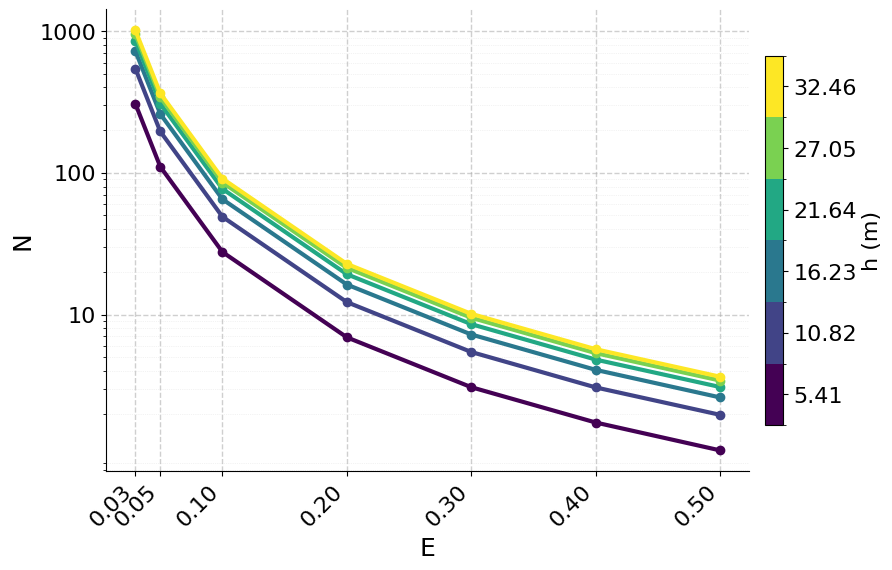

In [39]:
start = 5.41
# start = 19.5
num_values = 6
end = num_values * start


altitudes = np.round(np.linspace(start, end, num=num_values), decimals=2)
altitudes = np.round(np.linspace(start, end, num=num_values), decimals=2)

errors = np.array([0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.03])
n_per_e = plot_N_vs_E(altitudes, errors)

# Orthomap

In [56]:
annotation_path = os.path.join(proj_dir, "data/annotation.txt")
dataset_path = "/media/bota/BOTA/wheat/example-run-001_20241014T1739_ortho_dsm.tif"
tile_ortomappixel_path = os.path.join(proj_dir, "data/tiles_to_pixels.txt")

annotations_matrix = np.loadtxt(annotation_path, dtype=int)
rows = range(3, 113)
cols = range(13, 73)

In [54]:
def parse_tile_file(file_path):
    """
    Parse a text file containing tile information (pixel location in orthomap) and store it in an np.ndarray format.
    np.ndarray: A matrix where each element M[row][col] = [[X coord, X coord+length], [Y coord, Y coord+height]].
    """
    tile_data = {}
    max_row, max_col = 0, 0

    with open(file_path, "r") as file:
        for line in file:
            # Parse the line to extract row, col, and tile data
            parts = line.strip().split(":")
            tile_id = parts[0].strip()
            coords = list(map(int, parts[1].strip().split(",")))

            # Extract row and col from the tile ID
            row_col = tile_id.replace("tile", "").split("_")
            row = int(row_col[0])
            col = int(row_col[1])

            # Update max row and col values
            max_row = max(max_row, row)
            max_col = max(max_col, col)

            # Store in the dictionary
            tile_data[(row, col)] = coords

    # Create an empty matrix of appropriate size
    matrix = np.empty((max_row + 1, max_col + 1), dtype=object)

    for (row, col), coords in tile_data.items():
        y, x, length, height = coords
        matrix[row][col] = [[x, x + length], [y, y + height]]

    return matrix

In [57]:
# Load orthomap as img

dataset = gdal.Open(dataset_path)

band1 = dataset.GetRasterBand(1)  # Red channel
band2 = dataset.GetRasterBand(2)  # Green channel
band3 = dataset.GetRasterBand(3)  # Blue channel

b1 = band1.ReadAsArray()
b2 = band2.ReadAsArray()
b3 = band3.ReadAsArray()
img = np.dstack((b1, b2, b3))

tile_pixel_matrix = parse_tile_file(tile_ortomappixel_path)

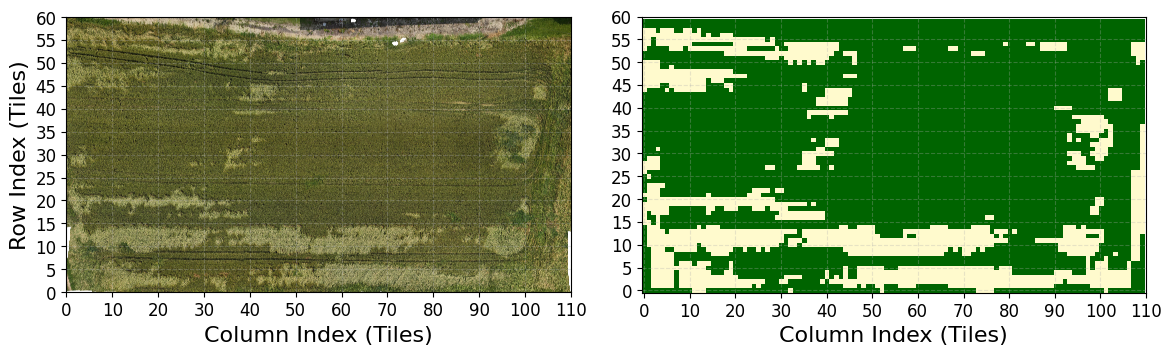

In [58]:
plt.figure(figsize=(12, 6))

# Left: Raw Image
plt.subplot(1, 2, 1)
# Convert tile range to pixel range using provided function
y_min, y_max = tile_pixel_matrix[3, 13][1][0], tile_pixel_matrix[112, 72][1][1]
x_min, x_max = tile_pixel_matrix[3, 13][0][0], tile_pixel_matrix[112, 72][0][1]
cropped_img = img[x_min:x_max, y_min:y_max]
cropped_img = np.transpose(cropped_img, (1, 0, 2))
plt.imshow(cropped_img, aspect="equal")
plt.xlabel("Column Index (Tiles)", fontsize=16)
plt.ylabel("Row Index (Tiles)", fontsize=16)

n_cols, n_rows = cropped_img.shape[:2]
cols_ = range(0, 60)
rows_ = range(0, 110)

x_ticks_img = np.linspace(0, n_rows, len(rows_) + 1)[::10]
y_ticks_img = np.linspace(0, n_cols, len(cols_) + 1)[::5]  #

plt.xticks(ticks=x_ticks_img, labels=np.arange(0, len(rows_) + 1, 10), fontsize=12)
plt.yticks(ticks=y_ticks_img, labels=np.arange(0, len(cols_) + 1, 5), fontsize=12)
plt.gca().invert_yaxis()
plt.grid(visible=True, linestyle="--", alpha=0.3)

# Right: Annotation Matrix
annotations_matrix_ = annotations_matrix.copy()
annotations_matrix_[annotations_matrix == 10] = 1
annotations_matrix_[annotations_matrix == 2] = 1
annotations_cropped = np.flipud(
    annotations_matrix_[3:113, 13:73].T
)  # Transpose for rotation
annotations_cropped = np.flip(annotations_cropped, axis=0)
plt.subplot(1, 2, 2)
cmap = mcolors.ListedColormap(["lemonchiffon", "darkgreen"])  # Define 2-color colormap

im = plt.imshow(
    annotations_cropped,
    aspect="equal",
    cmap=cmap,  # Change to 'Set1' for category contrast
    origin="lower",
    interpolation="nearest",
)

plt.xlabel("Column Index (Tiles)", fontsize=16)
plt.gca().set_ylabel("")
#  plt.ylabel("Row Index", fontsize=16)

plt.xticks(
    ticks=np.arange(0, len(rows) + 1, 10), labels=np.arange(0, 111, 10), fontsize=12
)
plt.yticks(
    ticks=np.arange(0, len(cols) + 1, 5), labels=np.arange(0, 61, 5), fontsize=12
)
plt.grid(visible=True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.savefig(
    os.path.join(proj_dir, "plots", "ortomap_highres.png"),
    dpi=600,
    bbox_inches="tight",
)
plt.show()

# Orthomap predictions

In [59]:
from binary_classifier.dataloader import WheatOthomapDataset

all_data = WheatOthomapDataset(dataset_path, annotation_path, tile_ortomappixel_path)

In [60]:
# Predict using othomap trained model
def predict_othomap(predictor):
    predictions_orto = {}
    batch_size = 128  # Define the maximum number of images per batch for predict_batch
    tiles = [(row, col) for row in range(3, 113) for col in range(13, 73)]
    batched_images = []
    batched_tiles = []
    pbar = tqdm(total=len(tiles))
    true_labels = []
    for tile_to_test in tiles:
        tile_img, tile_label = all_data.get_tile_info(tile_to_test)
        batched_images.append(tile_img)
        batched_tiles.append(tile_to_test)
        true_labels.append(tile_label)

        # Process the batch if it reaches the batch_size or if it's the last tile
        if len(batched_images) >= batch_size or tile_to_test == tiles[-1]:
            batch_predictions = predictor.predict_batch(
                batched_images
            )  # Predict for the batched images

            # Assign predictions back to their respective tiles
            for tile, prediction in zip(batched_tiles, batch_predictions):
                if tile not in predictions_orto:
                    predictions_orto[tile] = []
                predictions_orto[tile].append(prediction)

            # Clear the batch
            batched_images.clear()
            batched_tiles.clear()

        sleep(0.01)
        pbar.update(1)

    pbar.close()
    return predictions_orto, true_labels


def evaluate_confusion_matrix(pred_matrix, true_matrix, plot=True):
    # Flatten matrices to 1D arrays for evaluation
    y_pred = pred_matrix.flatten()
    y_true = true_matrix.flatten()

    # Compute confusion matrix
    labels = [0, 1]  # Classes: 0, 1, 2
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Convert confusion matrix to percentages
    confusion_mat_percent = cm / cm.sum(axis=1, keepdims=True) * 100
    print(f"Confusion Matrix (Percentage):\n{confusion_mat_percent}")

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(
        y_true, y_pred, average="weighted"
    )  # Use 'weighted' for multi-class
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")

    # Print metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    # Display confusion matrix
    if plot:
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=["lodged", "not lodged"],
        )
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()

    return cm


def evaluate_model(predictions_orto, true_labels, plot=True):
    rows = range(3, 113)
    cols = range(13, 73)
    pred_matrix = np.zeros((len(rows), len(cols)))
    true_matrix = np.zeros((len(rows), len(cols)))
    difference_matrix = np.zeros((len(rows), len(cols)))
    # Populate the raw_img_counts and persistence arrays
    for (row, col), preds in predictions_orto.items():
        row_idx = row - 3
        col_idx = col - 13
        pred = np.argmax(preds[0])
        # print(f"pred init:{preds} with argmax result:{arg}")

        pred_matrix[row_idx, col_idx] = pred
        true_matrix[row_idx, col_idx] = true_labels[row_idx * len(cols) + col_idx]
    difference_matrix = pred_matrix - true_matrix
    # Example usage:
    conf_matrix = evaluate_confusion_matrix(pred_matrix, true_matrix, plot=plot)
    if plot:

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(true_matrix, aspect="auto", cmap="plasma", origin="lower")
        plt.colorbar(label="labels")
        plt.gca().invert_yaxis()
        plt.title("Ground Truth Per Tile")
        plt.xlabel("Column Index")
        plt.ylabel("Row Index")
        plt.xticks(ticks=np.arange(0, len(cols), 5), labels=np.arange(13, 73, 5))
        plt.yticks(ticks=np.arange(0, len(rows), 10), labels=np.arange(3, 113, 10))

        plt.subplot(1, 3, 2)
        plt.imshow(pred_matrix, aspect="auto", cmap="plasma", origin="lower")
        plt.colorbar(label="Prediction Label")
        plt.title("Prediction std Per Tile")
        plt.xlabel("Column Index")
        plt.ylabel("Row Index")
        plt.gca().invert_yaxis()
        plt.xticks(ticks=np.arange(0, len(cols), 5), labels=np.arange(13, 73, 5))
        plt.yticks(ticks=np.arange(0, len(rows), 10), labels=np.arange(3, 113, 10))

        plt.subplot(1, 3, 3)
        plt.imshow(difference_matrix, aspect="auto", cmap="viridis", origin="lower")
        plt.colorbar(label="diff")
        plt.title("Difference Per Tile")
        plt.xlabel("Column Index")
        plt.ylabel("Row Index")
        plt.gca().invert_yaxis()
        plt.xticks(ticks=np.arange(0, len(cols), 5), labels=np.arange(13, 73, 5))
        plt.yticks(ticks=np.arange(0, len(rows), 10), labels=np.arange(3, 113, 10))

        # Show the plots
        plt.tight_layout()
        plt.show()
    else:
        print(conf_matrix)

100%|██████████| 6600/6600 [01:32<00:00, 71.46it/s]

Confusion Matrix (Percentage):
[[93.10113865  6.89886135]
 [ 2.74133542 97.25866458]]
Accuracy: 0.96
Precision: 0.96
Recall: 0.96
F1 Score: 0.96


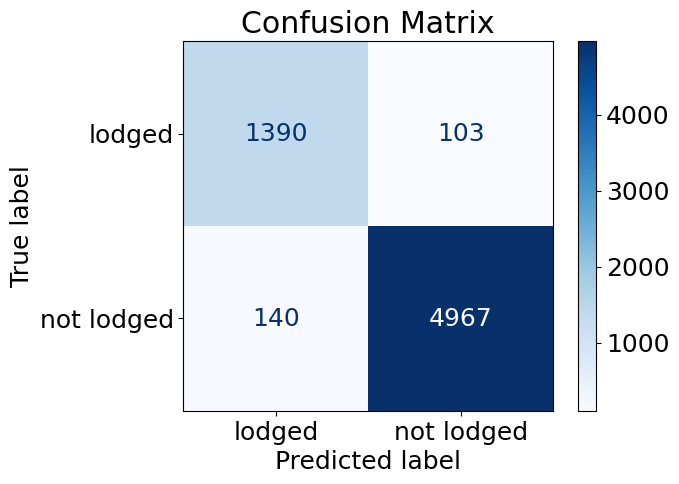

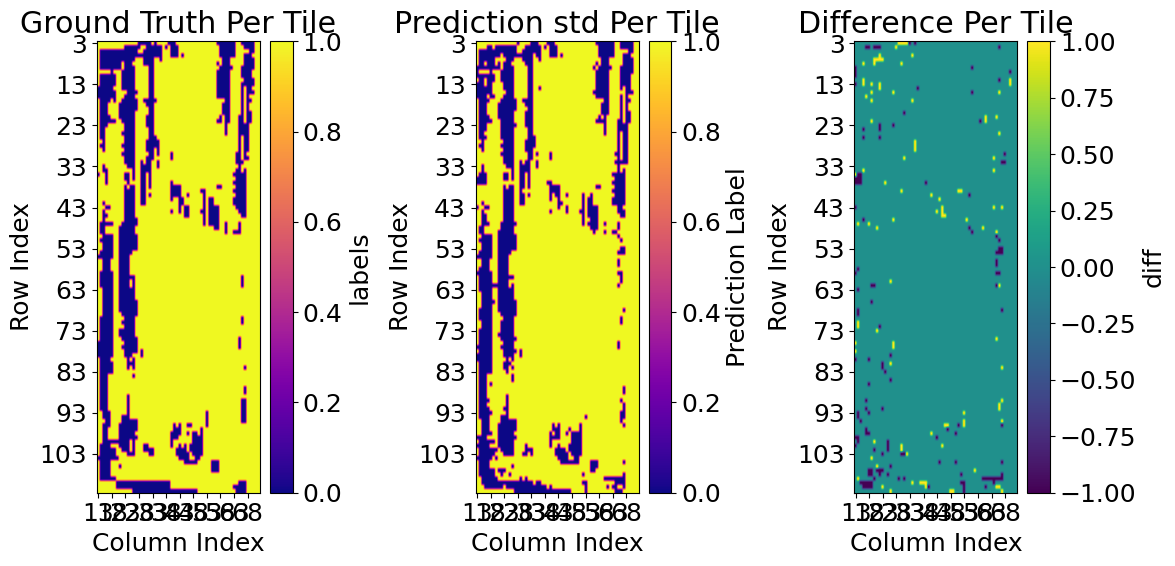

In [63]:
model_path = os.path.join(
    proj_dir,
    "binary_classifier",
    "models",
    "best_model_auc91_lr1_-05_bs128_wd_2.5-04.pth",
)

predictor = Predicter(model_weights_path=model_path, num_classes=2)
predictions_orto, true_labels = predict_othomap(predictor)
evaluate_model(predictions_orto, true_labels, plot=True)

# Blurred(h) orthomap predictions

h= [20, 26.5, 32, 38.5, 45, 51.5]

In [43]:
class img_sampler:
    def __init__(self):
        self.focal_length = 0.01229  # 12.29mm lens in meters
        self.sensor_width = 0.017424  # sensor width in meters
        self.sensor_height = 0.0130548  # sensor height in meters
        self.resolution_x = 5280  # horizontal resolution (number of pixels)
        self.resolution_y = 3956  # vertical resolution (number of pixels)
        self.fov_h, self.fov_v = self.calculate_fov()

    def calculate_fov(self):
        fov_horizontal = 2 * math.atan(self.sensor_width / (2 * self.focal_length))
        fov_vertical = 2 * math.atan(self.sensor_height / (2 * self.focal_length))
        return fov_horizontal, fov_vertical

    # Function to calculate the size of a 1m x 1m tile on the image in pixels
    def calculate_tile_size_on_image(self, altitude):
        # Calculate ground coverage at altitude
        coverage_horizontal = 2 * math.tan(self.fov_h / 2) * altitude
        coverage_vertical = 2 * math.tan(self.fov_v / 2) * altitude

        # Calculate tile size on image in pixels (1m x 1m tile)
        tile_size_image_horizontal = self.resolution_x / coverage_horizontal
        tile_size_image_vertical = self.resolution_y / coverage_vertical

        return int(tile_size_image_horizontal), int(tile_size_image_vertical)

    # Function to calculate the altitude from FOV and tile size on the image
    def calculate_altitude_from_fov_and_tile_size(self, size):
        tile_size_image_horizontal, tile_size_image_vertical = size
        # Calculate the ground coverage corresponding to the pixel size of the tile on the image
        coverage_horizontal = self.resolution_x / tile_size_image_horizontal
        coverage_vertical = self.resolution_y / tile_size_image_vertical

        # Calculate the altitude based on horizontal and vertical coverage
        altitude_horizontal = coverage_horizontal / (2 * math.tan(self.fov_h / 2))
        altitude_vertical = coverage_vertical / (2 * math.tan(self.fov_v / 2))

        # Average the two altitudes for a more accurate result
        altitude = (altitude_horizontal + altitude_vertical) / 2

        return altitude

In [44]:
s = img_sampler()


# Function for downsampling with Gaussian blur, with adjustable blur based on size
def downsample_with_blur(image, target_size, original_size):
    # Calculate blur strength based on size difference
    blur_radius = max(0.5, abs(original_size[0] - target_size[0]) / 50)

    blurred = image.filter(
        ImageFilter.GaussianBlur(radius=blur_radius)
    )  # Apply Gaussian blur
    return blurred.resize(target_size, Image.LANCZOS)


def plot_alt_pred(predictor, img_path, hs, img_i=None, plot=True):
    if isinstance(img_path, str):
        image = Image.open(img_path)
    else:
        image = img_path

    r0, c0 = image.size
    orig_size = (r0, c0)
    # Generate the 6 images
    alts = [round(s.calculate_altitude_from_fov_and_tile_size(orig_size), 2)]
    sizes = [orig_size]
    images = [image]
    predictions = [predictor.predict(image)]

    for i, h in enumerate(hs):
        target_size = s.calculate_tile_size_on_image(h)
        alts.append(h)
        sizes.append(target_size)
        if target_size[0] < image.size[0] and target_size[1] < image.size[1]:
            images.append(
                downsample_with_blur(image, target_size, orig_size)
            )  # Downsample with blur

        predictions.append(predictor.predict(images[-1]))
    if not plot:
        return predictions

    if plot:
        fig, axes = plt.subplots(1, len(predictions), figsize=(12, 5))
        axes = axes.flatten()
        print(f"raw img [{img_i}]: {img_path}")

        for i, ax in enumerate(axes):
            ax.imshow(images[i])

            if predictions[i][0] == 1:
                pred = "not lodged"
            elif predictions[i][0] == 0:
                pred = "lodged"
            else:
                pred = "other"

            if sizes[i] == orig_size:
                alt = "" + str(alts[i])
            else:
                alt = alts[i]

            ax.set_title(
                f"h={alt}m \n {sizes[i][0]}x{sizes[i][1]} px \n {pred}", fontsize=10
            )
            ax.axis("off")  # Hide axis

        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.show()

In [46]:
# Altitudes to test
hs = [20, 26.5, 32, 38.5, 45, 51.5]
hs = [round(19.5 + i * 7.79, 2) for i in range(6)]
print(hs)  # Output: [19.5, 27.29, 35.08, 42.87, 50.66, 58.45]


tiles = [(row, col) for row in range(3, 113) for col in range(13, 73)]


# Function to get predictions and store results
def collect_predictions():
    all_predictions = {h: [] for h in hs}
    all_labels = []

    for tile in tqdm(tiles, desc="Processing Tiles", leave=True):
        img_path, label = all_data.get_tile_info(tile)
        all_labels.append(label)

        pred = plot_alt_pred(predictor, img_path, hs, plot=False)
        for i, h in enumerate(hs):
            all_predictions[h].append(pred[i])

    return all_predictions, all_labels


# Compute accuracy per altitude
def compute_accuracy(all_predictions, all_labels):
    accuracies = {h: accuracy_score(all_labels, all_predictions[h]) for h in hs}

    conf_matrices = {h: confusion_matrix(all_labels, all_predictions[h]) for h in hs}

    false_negatives = {
        h: conf_matrices[h][1, 0] / 1493 for h in hs
    }  # FN = (actual 1, predicted 0)
    false_positives = {
        h: conf_matrices[h][0, 1] / 5107 for h in hs
    }  # FP = (actual 0, predicted 1)

    return accuracies, false_negatives, false_positives


# Plot Confusion Matrix for each altitude
def plot_confusion_matrices():
    for h in hs:
        cm = confusion_matrix(all_labels, all_predictions[h])
        plt.figure(figsize=(6, 5))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=[0, 1],
            yticklabels=[0, 1],
        )
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix at Altitude: {h}")
        plt.show()


# Main execution
all_predictions, all_labels = collect_predictions()

# plot_accuracy_curve(all_predictions, all_labels)
# plot_confusion_matrices()

[19.5, 27.29, 35.08, 42.87, 50.66, 58.45]


Processing Tiles: 100%|██████████| 6600/6600 [06:14<00:00, 17.64it/s]


In [ ]:
def plot_accuracy_curve(all_predictions, all_labels):
    accuracies, false_negatives, false_positives = compute_accuracy(
        all_predictions, all_labels
    )

    # Increase global font size
    plt.rcParams.update({"font.size": 18})

    # Create a single figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Accuracy Plot
    axes[0].plot(
        hs,
        list(accuracies.values()),
        marker="o",
        markersize=10,  # Increased marker size
        linestyle="-",
        color="black",
        linewidth=4,  # increased line width
    )
    axes[0].set_xlabel("Altitude", fontsize=18)
    axes[0].set_ylabel("Accuracy", fontsize=18)
    axes[0].grid(True, linestyle="--", alpha=0.6)

    # Error Rate Plot
    axes[1].plot(
        hs,
        list(false_negatives.values()),
        marker="x",
        markersize=10,  # Increased marker size
        linestyle="--",
        color="black",
        label="False Negatives",
        linewidth=4,  # increased line width
    )
    axes[1].plot(
        hs,
        list(false_positives.values()),
        marker="o",
        markersize=10,  # Increased marker size
        linestyle="-",  # Changed to dashed line
        color="black",
        label="False Positives",
        linewidth=4,  # increased line width
    )
    axes[1].set_xlabel("Altitude", fontsize=18)
    axes[1].set_ylabel("Error Rate", fontsize=18)
    axes[1].legend(loc="upper left", fontsize=16)  # Moved legend to top left
    axes[1].grid(True, linestyle="--", alpha=0.6)

    # Adjust layout
    plt.tight_layout()

    # Save the figure
    plt.savefig(os.path.join(proj_dir, "plots", "accuracy_error_plots.png"), dpi=300)

    # Show the figure
    plt.show()

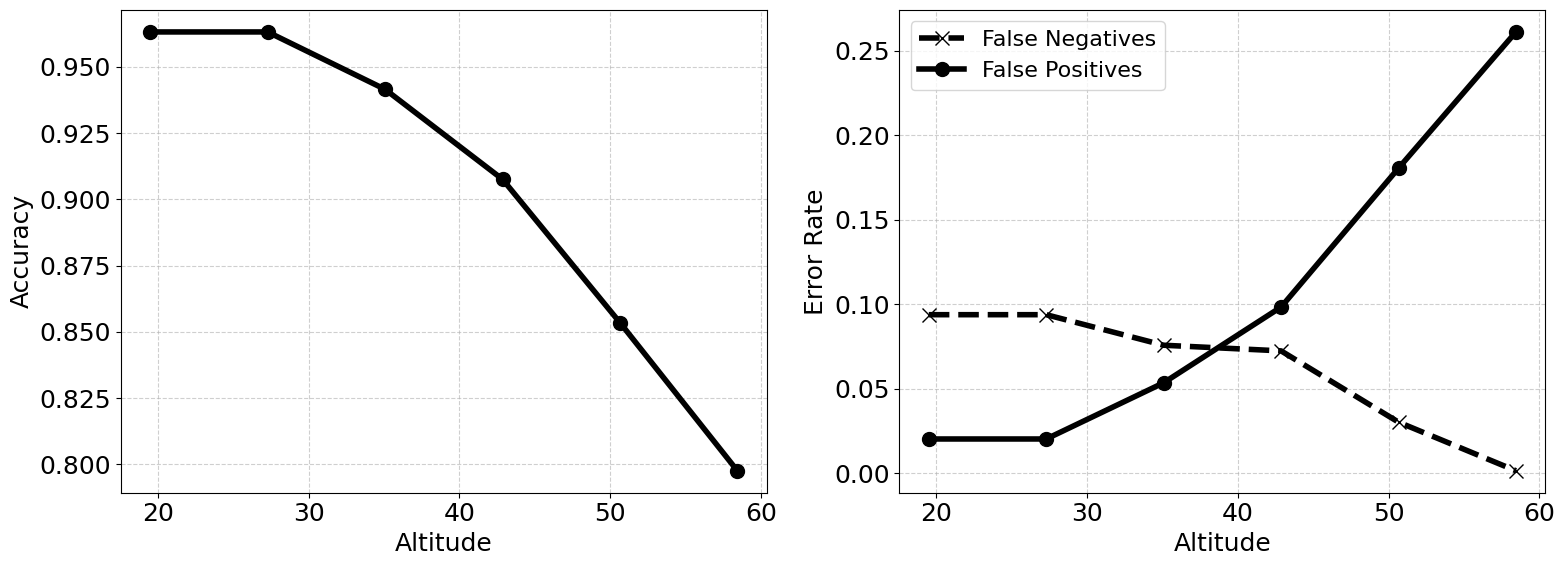

In [62]:
plot_accuracy_curve(all_predictions, all_labels)